In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn import metrics, impute
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error, r2_score, roc_curve, auc,pairwise_distances
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import GridSearchCV, ParameterGrid
from sklearn.ensemble import BaggingRegressor, BaggingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from six import StringIO
from IPython.display import Image
import time as time
import skimpy as skim
import statsmodels.formula.api as smf


In [49]:
life_expectancy_train = pd.read_csv("life_expectancy_train2.csv")
life_expectancy_test = pd.read_csv("life_expectancy_test2.csv")

In [50]:
print(life_expectancy_train.columns.tolist())

['Unnamed: 0', 'Country', 'Year', 'Status', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling']


In [51]:
life_expectancy_train = pd.get_dummies(data = life_expectancy_train, columns = ['Status'])
life_expectancy_test = pd.get_dummies(data = life_expectancy_test, columns = ['Status'])

In [52]:
print(life_expectancy_train.columns.tolist())

['Unnamed: 0', 'Country', 'Year', 'Life expectancy ', 'Adult Mortality', 'infant deaths', 'Alcohol', 'percentage expenditure', 'Hepatitis B', 'Measles ', ' BMI ', 'under-five deaths ', 'Polio', 'Total expenditure', 'Diphtheria ', ' HIV/AIDS', 'GDP', 'Population', ' thinness  1-19 years', ' thinness 5-9 years', 'Income composition of resources', 'Schooling', 'Status_Developed', 'Status_Developing']


In [53]:
life_expectancy_train = skim.clean_columns(life_expectancy_train)

In [54]:
life_expectancy_test = skim.clean_columns(life_expectancy_test)

In [55]:
life_expectancy_train.head()

,unnamed_0,country,year,life_expectancy,adult_mortality,infant_deaths,alcohol,percentage_expenditure,hepatitis_b,measles,...,diphtheria,hiv_aids,gdp,population,thinness_1_19_years,thinness_5_9_years,income_composition_of_resources,schooling,status_developed,status_developing
0,645,Croatia,2011,77.0,14.0,0,12.19,1913.356642,97.0,12,...,96.0,0.1,14539.184210,428622.0,1.6,1.5,0.808,14.5,True,False
1,2089,Republic of Korea,2013,81.7,68.0,1,9.33,0.000000,99.0,107,...,99.0,0.1,NaN,NaN,1.5,1.0,NaN,NaN,False,True
2,1323,Japan,2006,82.4,68.0,3,7.49,6502.136974,NaN,520,...,98.0,0.1,35433.988960,127854.0,1.7,1.5,0.873,14.9,True,False
3,1812,Nauru,2013,NaN,NaN,0,0.01,15.606596,87.0,0,...,87.0,0.1,136.183210,NaN,0.1,0.1,NaN,9.6,False,True
4,1621,Mali,2012,57.2,27.0,53,0.01,96.546583,66.0,341,...,66.0,1.5,777.347687,16667.0,8.3,8.1,0.411,7.7,False,True


In [56]:
life_expectancy_train.columns[life_expectancy_train.isnull().any()]

Index(['life_expectancy', 'adult_mortality', 'alcohol', 'hepatitis_b', 'bmi',
       'polio', 'total_expenditure', 'diphtheria', 'gdp', 'population',
       'thinness_1_19_years', 'thinness_5_9_years',
       'income_composition_of_resources', 'schooling'],
      dtype='object')

In [57]:
def fill_data_train(data):
    data = data.drop(columns = ['adult_mortality', 'country'])
    sk.metrics.pairwise.nan_euclidean_distances(data, data)
    imputer = sk.impute.KNNImputer(n_neighbors = 2)
    #Scaling data to compute equally weighted distances from the 'k' nearest neighbors
    scaler = sk.preprocessing.MinMaxScaler()
    scaled_data = pd.DataFrame(scaler.fit_transform(data))
    imputer = sk.impute.KNNImputer(n_neighbors=3, weights="uniform")
    imputed_arr = imputer.fit_transform(scaled_data)
    #Scaling back the scaled array to obtain the data at the actual scale
    unscaled_data = scaler.inverse_transform(imputed_arr)
    #Imputed missing values
    data_imputed = data.copy()
    data_imputed.loc[:, "alcohol"] = unscaled_data[:,4]
    data_imputed.loc[:, 'hepatitis_b'] = unscaled_data[:,6]
    data_imputed.loc[:, 'bmi'] = unscaled_data[:,8]
    data_imputed.loc[:, 'total_expenditure'] = unscaled_data[:,11]
    data_imputed.loc[:, 'polio'] = unscaled_data[:,10]
    data_imputed.loc[:, 'diphtheria'] = unscaled_data[:,12]
    data_imputed.loc[:, 'gdp'] = unscaled_data[:,14]
    data_imputed.loc[:, 'population'] = unscaled_data[:,15]
    data_imputed.loc[:, 'thinness_1_19_years'] = unscaled_data[:,16]
    data_imputed.loc[:, 'thinness_5_9_years'] = unscaled_data[:,17]
    data_imputed.loc[:, 'income_composition_of_resources'] = unscaled_data[:,18]
    data_imputed.loc[:, 'schooling'] = unscaled_data[:,19]
   
    
    return data_imputed['hepatitis_b'], data_imputed["alcohol"], data_imputed['bmi'], data_imputed['total_expenditure'], data_imputed['polio'], data_imputed['diphtheria'],data_imputed['gdp'], data_imputed['population'],data_imputed['thinness_1_19_years'],data_imputed['thinness_5_9_years'],data_imputed['income_composition_of_resources'],data_imputed['schooling']
   


In [58]:
life_expectancy_train['hepatitis_b'], life_expectancy_train["alcohol"], life_expectancy_train['bmi'], life_expectancy_train['total_expenditure'], life_expectancy_train['polio'], life_expectancy_train['diphtheria'],life_expectancy_train['gdp'], life_expectancy_train['population'],life_expectancy_train['thinness_1_19_years'],life_expectancy_train['thinness_5_9_years'],life_expectancy_train['income_composition_of_resources'],life_expectancy_train['schooling'] = fill_data_train(life_expectancy_train)

In [59]:
life_expectancy_train.columns[life_expectancy_train.isnull().any()]

Index(['life_expectancy', 'adult_mortality'], dtype='object')

# Visualizations

<Axes: >

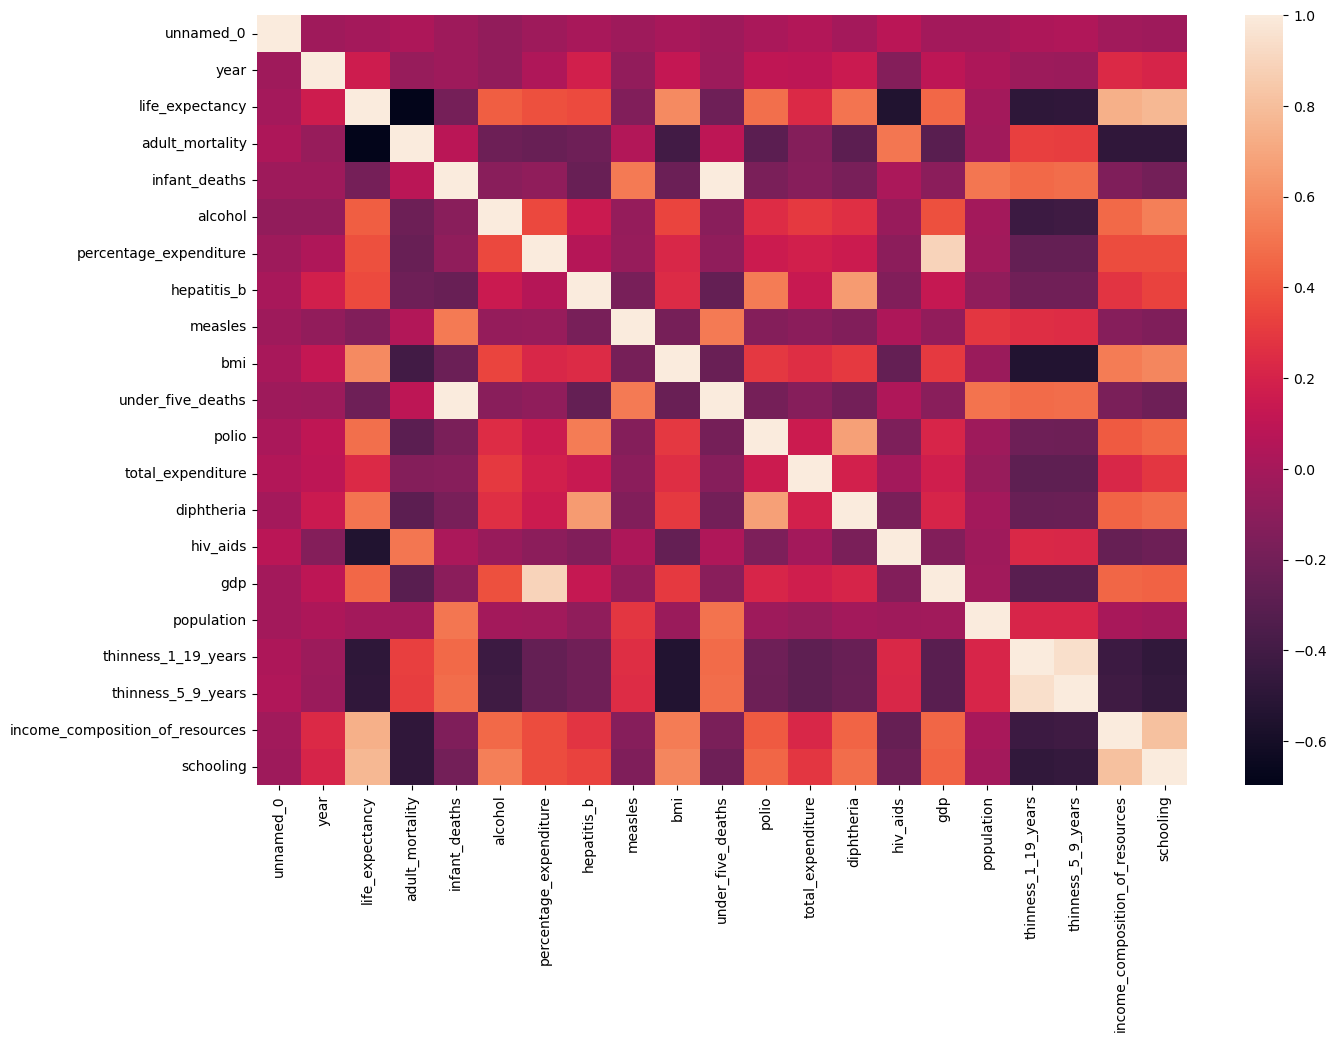

In [60]:
numeric_data = life_expectancy_train.select_dtypes(include=[np.number])

corr = numeric_data.corr()

plt.subplots(figsize=(15, 10))
sns.heatmap(corr)

<Axes: xlabel='year', ylabel='life_expectancy'>

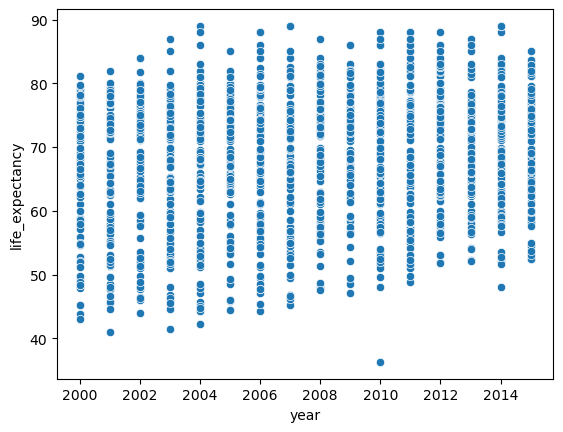

In [61]:
sns.scatterplot(x = 'year', y= 'life_expectancy', data = life_expectancy_train)

Year does not have a clear relationship to the predictor. The data is from 2000 to 2015, and significant life expectancy improvements happen over extended periods of time

<Axes: xlabel='adult_mortality', ylabel='life_expectancy'>

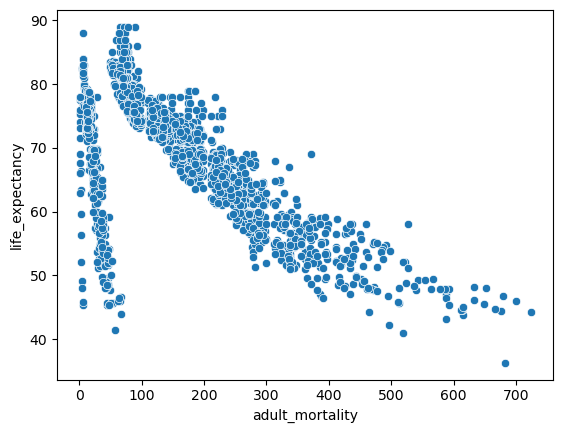

In [62]:
sns.scatterplot(x = 'adult_mortality', y = 'life_expectancy', data = life_expectancy_train)

There is a general negative trend with mortality, but there are some countries
that have very low mortality figures.

<Axes: xlabel='income_composition_of_resources', ylabel='life_expectancy'>

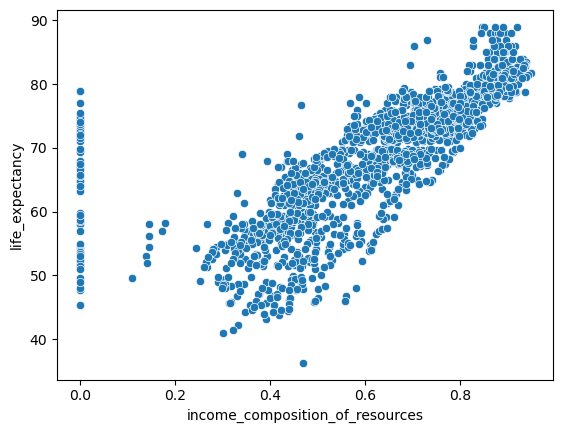

In [63]:
sns.scatterplot(x = 'income_composition_of_resources', y = 'life_expectancy', data = life_expectancy_train)

<Axes: xlabel='thinness_1_19_years', ylabel='life_expectancy'>

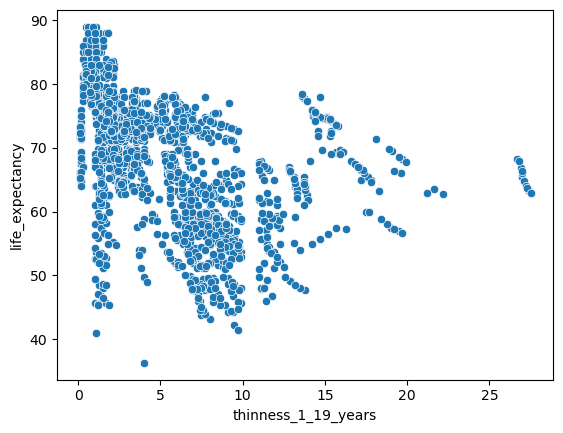

In [64]:
sns.scatterplot(x = 'thinness_1_19_years', y = 'life_expectancy', data = life_expectancy_train)

There is a lot of noise and less clarity in this plot

<Axes: xlabel='income_composition_of_resources', ylabel='life_expectancy'>

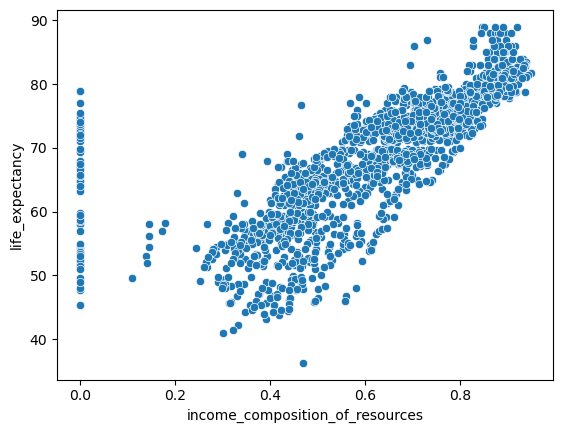

In [65]:
sns.scatterplot(x = 'income_composition_of_resources', y = 'life_expectancy', data = life_expectancy_train)

# Linear Regression Model

In [66]:
print(life_expectancy_train.columns.tolist())

['unnamed_0', 'country', 'year', 'life_expectancy', 'adult_mortality', 'infant_deaths', 'alcohol', 'percentage_expenditure', 'hepatitis_b', 'measles', 'bmi', 'under_five_deaths', 'polio', 'total_expenditure', 'diphtheria', 'hiv_aids', 'gdp', 'population', 'thinness_1_19_years', 'thinness_5_9_years', 'income_composition_of_resources', 'schooling', 'status_developed', 'status_developing']


In [67]:
formula = ('life_expectancy ~ year + status_developed + status_developing + adult_mortality + infant_deaths + '
           'alcohol + percentage_expenditure + hepatitis_b + measles + bmi + under_five_deaths + '
           'polio + total_expenditure + diphtheria + hiv_aids + gdp + population + thinness_1_19_years + '
           'thinness_5_9_years + income_composition_of_resources + schooling')


ols_object = smf.ols(formula=formula, data=life_expectancy_train)
model = ols_object.fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:        life_expectancy   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.835
Method:                 Least Squares   F-statistic:                     503.5
Date:                Tue, 30 Jan 2024   Prob (F-statistic):               0.00
Time:                        10:31:52   Log-Likelihood:                -5529.4
No. Observations:                1994   AIC:                         1.110e+04
Df Residuals:                    1973   BIC:                         1.122e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [69]:
life_expectancy_test = life_expectancy_test.dropna()
rmse = round(np.sqrt(mean_squared_error(life_expectancy_test.life_expectancy,model.predict(life_expectancy_test))), 3)
print("The linear model gave an RMSE = " + str(rmse))

# Key Takeaways

After seeing the visualizations and creating the base
model, it's clear that a simple linear regression with multiple predictors is not enough.

The RMSE is above 3.5, and this can definitely be reduced by following non-linear approaches, especially regression
trees. I also need to make sure that there is better variable selection before building non-linear models. 

I removed three predictors: adult mortality, under 5 deaths, and infant deaths. My project is aimed to identify social and economic factors that influence life expectancy, focusing on those that governments can impact. Consequently, I excluded GDP, population, and year as predictors, as they are not within a country's control. This left me with 15 remaining predictors to build my ensemble model, combining various tree-based approaches to minimize RMSE.